# Filter Zero Outter Analysis

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from experiments.experiment import Experiment

c:\Users\Majo\.conda\envs\masters\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
relevant_columns = ["error", "energy", "area", "delay", "gate_count"]
# experiment = Experiment.with_data_only("../../data_store/zero_outter/conv1_0_0")
experiment = Experiment.with_data_only("../../mse_test/single_filter")
df = experiment.get_train_statistics(names=["run", "generation", "t", "error", "energy", "area", "delay", "depth", "gate_count", "chromosome"])
df = experiment.get_model_metrics(names=["run", "generation", "t", "error", "energy", "area", "delay", "depth", "gate_count", "chromosome"])
df["run"] = df["run"].astype("int")
df["t"] = df["t"].astype("int")
df["generation"] = df["generation"].astype("int")
df["error"] = df["error"].astype("int")
df["energy"] = df["energy"].astype("float")
df["area"] = df["area"].astype("float")
df["delay"] = df["delay"].astype("float")
# df["gate_count"] = df["gate_count"].astype("int")
df.drop(columns="depth", inplace=True, errors="ignore")
df


TypeError: Experiment.get_train_statistics() got an unexpected keyword argument 'names'

## Data Exploration Analysis

In [54]:
for col in relevant_columns:
    print(df[col].dropna().describe())

count     1119.000000
mean      2117.370867
std       7453.624221
min          0.000000
25%          0.000000
50%          0.000000
75%         40.500000
max      67133.000000
Name: error, dtype: float64
count    6.280000e+02
mean     9.732909e-03
std      3.846985e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.500000e-07
max      3.035350e-01
Name: energy, dtype: float64
count    628.000000
mean      34.635535
std      104.713681
min        0.000000
25%        0.000000
50%        0.000000
75%        0.351975
max      790.301195
Name: area, dtype: float64
count    539.000000
mean       0.031614
std        0.131724
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.730000
Name: delay, dtype: float64
count    523.000000
mean       5.173996
std        3.869313
min        1.000000
25%        1.000000
50%        4.000000
75%        8.000000
max       20.000000
Name: gate_count, dtype: float64


## Data Preparation

In [117]:
# clean_df = df.dropna()
clean_df = df.copy()

for run in range(1, experiment.get_number_of_train_statistic_file() + 1):
    condition = (clean_df["run"] == run) & (clean_df["generation"].isna())
    clean_df.loc[condition, relevant_columns] = clean_df.loc[condition, relevant_columns].min()

# clean_df.loc[clean_df["error"].isna(), :].tail(20)
clean_df

,run,generation,t,error,energy,area,delay,gate_count,chromosome
0,1,1,0,11008,NaN,NaN,NaN,NaN,"{9,16,5,5,2,5,5}([9]2,4,18)([10]7,6,15)([11]0,..."
1,1,2,0,10285,NaN,NaN,NaN,NaN,"{9,16,5,5,2,5,5}([9]2,4,18)([10]7,6,15)([11]7,..."
2,1,3,0,6227,NaN,NaN,NaN,NaN,"{9,16,5,5,2,5,5}([9]2,4,18)([10]7,6,15)([11]7,..."
3,1,4,0,3797,NaN,NaN,NaN,NaN,"{9,16,5,5,2,5,5}([9]2,4,18)([10]7,4,15)([11]7,..."
4,1,5,0,3782,NaN,NaN,NaN,NaN,"{9,16,5,5,2,5,5}([9]2,4,18)([10]7,4,15)([11]7,..."
...,...,...,...,...,...,...,...,...,...
1114,30,87123,15,0,0.0,0.0,0.0,1.0,"{9,16,5,5,2,5,5}([9]0,8,25)([10]8,3,11)([11]6,..."
1115,30,337124,61,0,0.0,0.0,0.0,1.0,"{9,16,5,5,2,5,5}([9]0,8,10)([10]1,7,14)([11]2,..."
1116,30,587125,107,0,0.0,0.0,0.0,1.0,"{9,16,5,5,2,5,5}([9]2,5,23)([10]3,3,2)([11]4,1..."
1117,30,837126,152,0,0.0,0.0,0.0,1.0,"{9,16,5,5,2,5,5}([9]0,1,7)([10]7,3,5)([11]7,4,..."


## Evolution Progress

C:\Users\Majo\AppData\Local\Temp\ipykernel_2624\2664694428.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantized_df = filtered_df.loc[:, relevant_columns + ["run"]].groupby(by=[quantizer, "run"]).mean()
c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Majo\.conda\envs\masters\Lib\site-pac

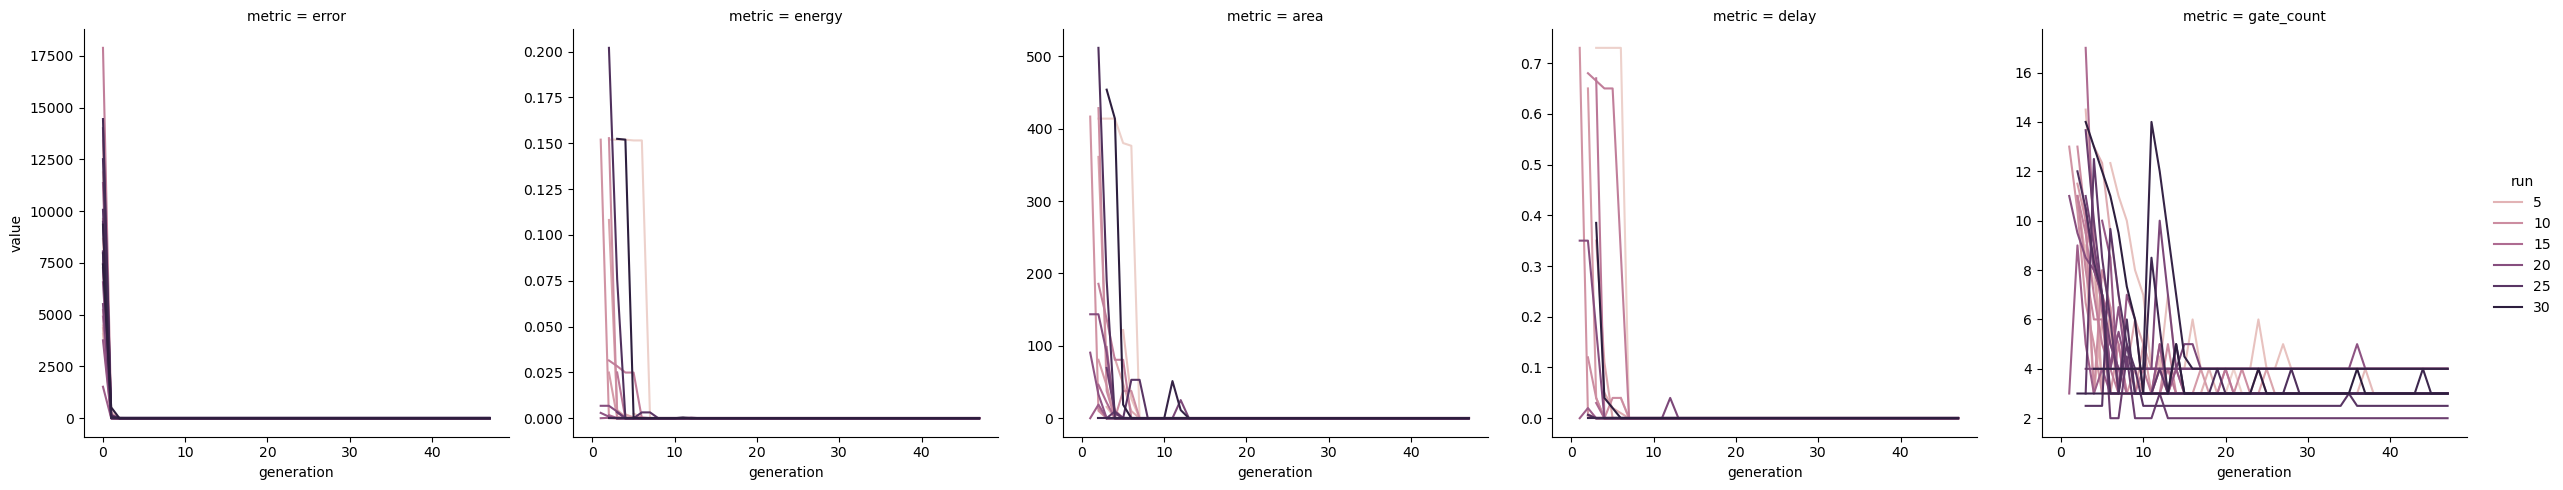

''

In [171]:
generation_group = 10
bin_quantity = 50
# Create a 2x3 subplot layout
# fig, axes = plt.subplots(2, 3, figsize=(15, 10))

filtered_df = clean_df.loc[clean_df["generation"] <= (generation_group * bin_quantity), :]

bins = np.arange(0, filtered_df["generation"].max() + generation_group, generation_group)
quantizer = pd.cut(filtered_df["generation"], bins=bins)
quantized_df = filtered_df.loc[:, relevant_columns + ["run"]].groupby(by=[quantizer, "run"]).mean()
quantized_df.reset_index(inplace=True)

for run in range(1, experiment.get_number_of_train_statistic_file() + 1):
    condition = (quantized_df["run"] == run) & (quantized_df["error"].isna())
    for col in relevant_columns:
        quantized_df.loc[condition, col] = quantized_df.loc[quantized_df["run"] == run, col].min(skipna=True)


quantized_df = pd.melt(quantized_df, id_vars=["run", "generation"], value_vars=relevant_columns, var_name="metric", value_name="value")
quantized_df["generation"] = quantized_df["generation"].cat.codes
quantized_df = quantized_df.loc[quantized_df["generation"] < 50, :]
sns.relplot(data=quantized_df, x="generation", y="value", hue="run", col="metric", kind="line", facet_kws={'sharey': False})
plt.show()
;

,run,generation,t,error,energy,area,delay,gate_count,chromosome
0,1,1,0,11008,NaN,NaN,NaN,NaN,"{9,16,5,5,2,5,5}([9]2,4,18)([10]7,6,15)([11]0,..."
1,1,2,0,10285,NaN,NaN,NaN,NaN,"{9,16,5,5,2,5,5}([9]2,4,18)([10]7,6,15)([11]7,..."
2,1,3,0,6227,NaN,NaN,NaN,NaN,"{9,16,5,5,2,5,5}([9]2,4,18)([10]7,6,15)([11]7,..."
3,1,4,0,3797,NaN,NaN,NaN,NaN,"{9,16,5,5,2,5,5}([9]2,4,18)([10]7,4,15)([11]7,..."
4,1,5,0,3782,NaN,NaN,NaN,NaN,"{9,16,5,5,2,5,5}([9]2,4,18)([10]7,4,15)([11]7,..."
...,...,...,...,...,...,...,...,...,...
1114,30,87123,15,0,0.0,0.0,0.0,1.0,"{9,16,5,5,2,5,5}([9]0,8,25)([10]8,3,11)([11]6,..."
1115,30,337124,61,0,0.0,0.0,0.0,1.0,"{9,16,5,5,2,5,5}([9]0,8,10)([10]1,7,14)([11]2,..."
1116,30,587125,107,0,0.0,0.0,0.0,1.0,"{9,16,5,5,2,5,5}([9]2,5,23)([10]3,3,2)([11]4,1..."
1117,30,837126,152,0,0.0,0.0,0.0,1.0,"{9,16,5,5,2,5,5}([9]0,1,7)([10]7,3,5)([11]7,4,..."


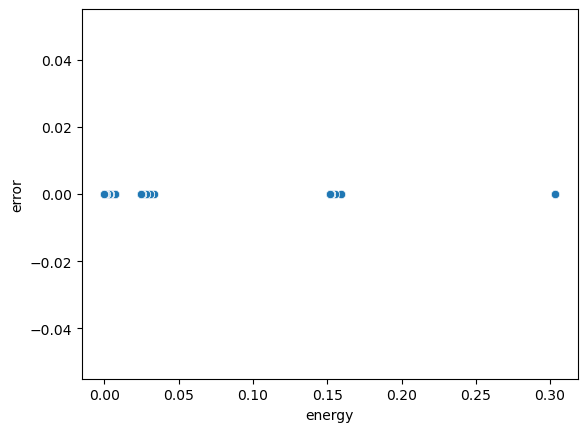

In [177]:
sns.scatterplot(data=clean_df.loc[clean_df["error"].notna() & clean_df["energy"].notna()], x="energy", y="error")
# plt.show()
clean_df